In [1]:

from matplotlib import pyplot as plt
import os
import numpy as np
import glob
import os

## astropy
import astropy.units as u
from astropy.table import Table

## ctapipe
from ctapipe_io_nectarcam import NectarCAMEventSource 
from ctapipe.io import event_source, EventSeeker

import scipy.stats as scsp
from scipy.stats import poisson                                                                                                             

from fit_ses_v6 import *
#import seaborn as sns




/local/home/ttaverni/anaconda3/envs/nectarchain-dev/lib/python3.7/site-packages/corsikaio/subblocks/dtypes.py:20: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  return np.dtype(dict(**dt))


In [2]:
plt.rcParams['figure.figsize'] = [15, 7]

In [3]:
        #MC_file_path = '/media/ttaverni/Transcend/MC_s/Heide/test_ff_200pe_newWF.simtel.gz'
        #MC_file_path = '/media/ttaverni/Transcend/MC_s/Heide/test_ff_200pe_newWF_1kev.simtel.gz'
        MC_file_path = '/media/ttaverni/Transcend/MC_s/Heide/test_ff_200pe_WF1010_noise36_TTled.simtel.gz'
        
        inputfile_reader_MC = event_source(
            input_url = MC_file_path,
            max_events=1000)
        all_QMC = []
        all_wfs = []
        for ii, event in enumerate(inputfile_reader_MC):
            all_wfs.append(event.r0.tel[1].waveform[:,:])
            all_QMC.append(event.mc.tel[1].photo_electron_image)
        wfs_MC    = np.array(all_wfs)
        all_QMC   = np.array(all_QMC)
        ped_MC = event.mc.tel[1].pedestal/64

In [4]:
        #data_file_path = "/media/ttaverni/Transcend/data/scans_08019/NectarCAM.Run1568.00[0-9][0-9].fits.fz"
        data_file_path = "/media/ttaverni/Transcend/data/scans_08019/NectarCAM.Run1557.00[0-9][0-9].fits.fz"
        
        inputfile_reader = NectarCAMEventSource(
            input_url = data_file_path,
            max_events=50000)

        cfg = inputfile_reader.camera_config
        pix_ids = cfg.expected_pixels_id[:]
        all_wfs = []
        pedwfs = []
        AQ=[]
        for ii, event in enumerate(inputfile_reader):
            Qm = (event.r0.tel[event.r0.tels_with_data[0]].waveform[0,pix_ids,:]-250.).sum(axis=1).mean()/58.
            AQ.append(Qm)
            if ii <1000:
                pedwfs.append(event.r0.tel[event.r0.tels_with_data[0]].waveform[:,pix_ids])
            if Qm >150 and Qm<250:
                all_wfs.append(event.r0.tel[event.r0.tels_with_data[0]].waveform[:,pix_ids])
                if len(all_wfs)>1000:
                    break
        wfs_data = np.array(all_wfs)
        pedwfs   = np.array(pedwfs).mean(axis=0)

In [5]:
all_wfs=[]
wfs_MC.shape

(1000, 2, 1855, 64)

In [6]:
maxs_MC = wfs_MC.argmax(axis=3).flatten()
maxs_data = wfs_data.argmax(axis=3).flatten()

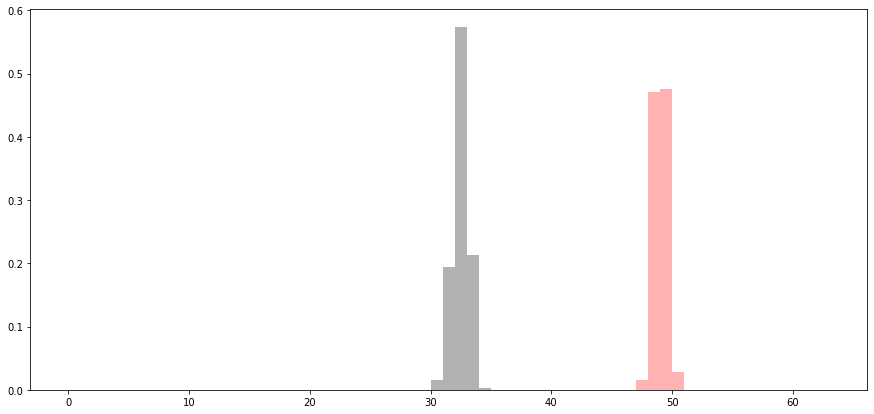

In [7]:
h = plt.hist(maxs_MC,  bins=np.arange(0,64),density=1,alpha=.3,color='red')
h = plt.hist(maxs_data,bins=np.arange(0,64),density=1,alpha=.3,color='black')

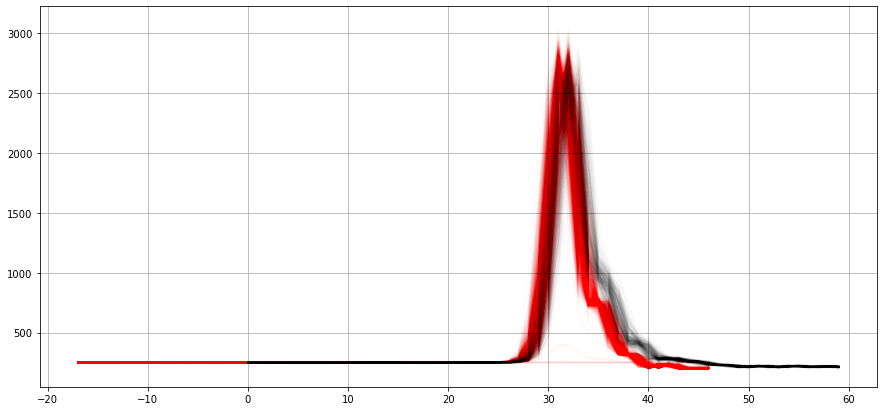

In [8]:
wfs_means_MC = wfs_MC[:,0].mean(axis=0)
wfs_means_MC = wfs_MC[:,0].mean(axis=0)
wfs_means_data = wfs_data[:,0].mean(axis=0)

p = plt.plot(np.arange(0,64)-17,wfs_means_MC.T,alpha=.01,color='red')
p = plt.plot(wfs_means_data.T,alpha=.01,color='black')
plt.gca().grid()

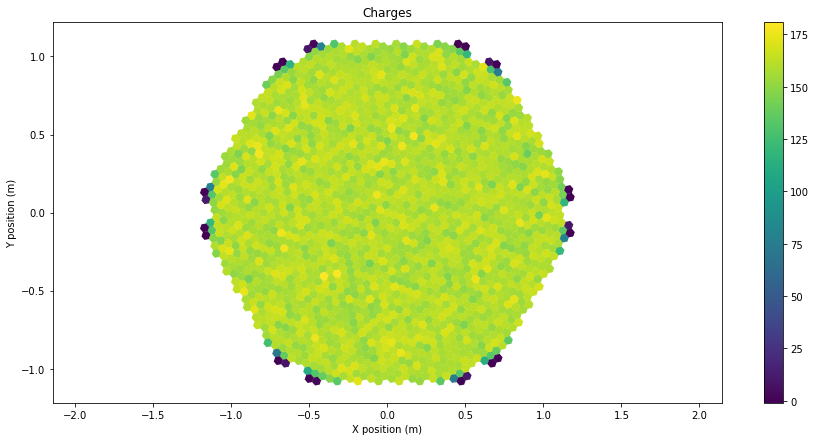

In [9]:

geom = CameraGeometry.from_name("NectarCam")

Qs = (wfs_means_MC[:,40:56]-250).sum(axis=1)/58.
Qs_data = (wfs_means_data[:,25:45]-250).sum(axis=1)/58.

disp1 = CameraDisplay(geom,title='Charges')
disp1.add_colorbar()
disp1.image = Qs

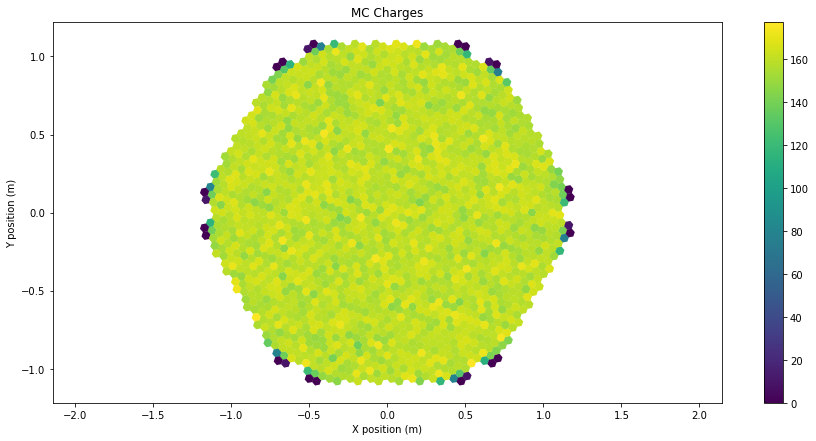

In [10]:
disp1 = CameraDisplay(geom,title='MC Charges')
disp1.add_colorbar()
disp1.image = all_QMC.mean(axis=0)

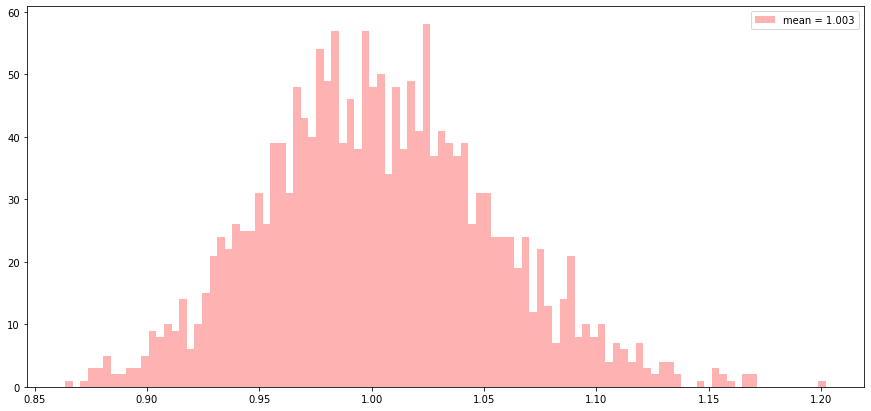

In [11]:
mmask = all_QMC.mean(axis=0)>20
mmean = np.mean(Qs[mmask]/all_QMC.mean(axis=0)[mmask])
h = plt.hist(Qs[mmask]/all_QMC.mean(axis=0)[mmask],100,color = 'red',alpha=.3,label= 'mean = {:.4}'.format(mmean))
l = plt.gca().legend()

Text(0.5, 1.0, 'Charge dispertion (at $\\sim$170 p.e.)')

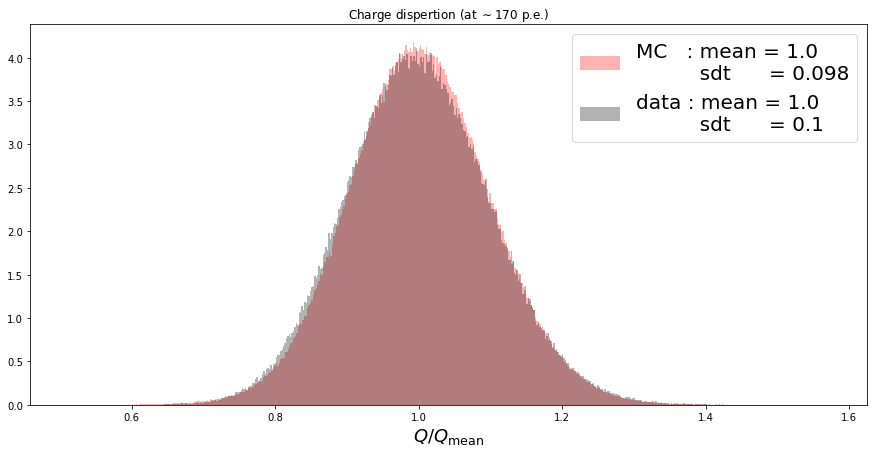

In [12]:
aaa = all_QMC.flatten()
mm = aaa > 100
QQQs = (wfs_MC[:,0,:,40:56]-250.).sum(axis=2)/58.
QQQsdat = ((wfs_data[:,0,:,20:40]-pedwfs[0,:,20:40]).sum(axis=2)/58.).flatten()

evtmean = np.mean(QQQs.flatten()[mm]/aaa[mm])

mmean = np.mean(QQQs.flatten()[mm])/aaa[mm].mean()
sstd  = np.std(QQQs.flatten()[mm])/aaa[mm].mean()

#h = plt.hist(QQQs.flatten()[mm]/aaa[mm],100,color = 'red',alpha=.3,label= 'mean = {:.4}'.format(mmean),density=1)
h = plt.hist(QQQs.flatten()[mm]/(aaa[mm].mean()),500,color = 'red',alpha=.3,\
             label= 'MC   : mean = {:.3} \n          sdt      = {:.2}'.format(mmean,sstd),density=1)

h = plt.hist(QQQsdat/QQQsdat.mean(),500,color = 'black',alpha=.3,\
             label= 'data : mean = {:.3} \n          sdt      = {:.2}'.format(1.,(QQQsdat/QQQsdat.mean()).std()),density=1)

l = plt.gca().legend(prop={'size': 20})
(QQQsdat/QQQsdat.mean()).std()
#(QQQs.flatten()[mm]).std()/(aaa[mm].mean())
plt.gca().set_xlabel('$Q/Q_\mathrm{mean}$',fontsize=18)
#plt.gca().set_yscale('log')
plt.gca().set_title("Charge dispertion (at $\sim$170 p.e.)")

Text(0.5, 1.0, 'Charge dispertion (at $\\sim$170 p.e.)')

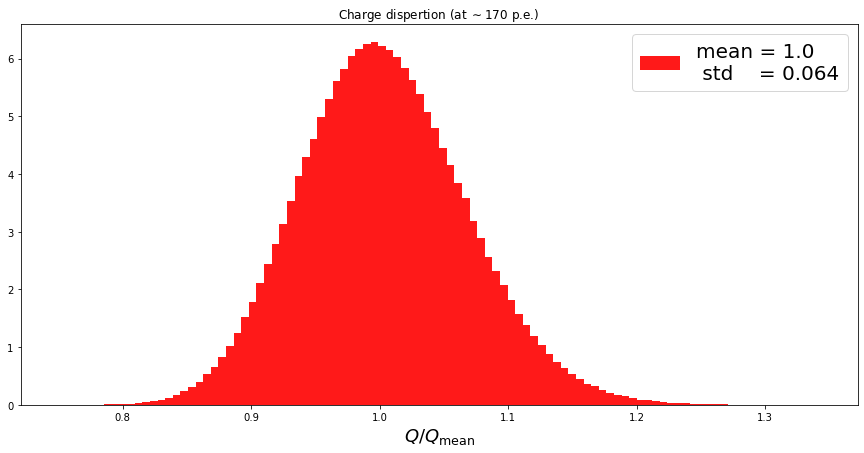

In [13]:
aaa = all_QMC.flatten()
mm = aaa > 100
QQQs = (wfs_MC[:,0,:,40:56]-250.).sum(axis=2)/58.

evtmean = np.mean(QQQs.flatten()[mm]/aaa[mm])

mmean = np.mean(QQQs.flatten()[mm])/aaa[mm].mean()
sstd  = np.std(QQQs.flatten()[mm])/aaa[mm].mean()

h = plt.hist(QQQs.flatten()[mm]/aaa[mm],100,color = 'red',alpha=.9,\
             label= 'mean = {:.3} \n std    = {:.2}'.format(evtmean,np.std(QQQs.flatten()[mm]/aaa[mm].flatten())),density=1)

l = plt.gca().legend(prop={'size': 20})
(QQQsdat/QQQsdat.mean()).std()
#(QQQs.flatten()[mm]).std()/(aaa[mm].mean())
plt.gca().set_xlabel('$Q/Q_\mathrm{mean}$',fontsize=18)
#plt.gca().set_yscale('log')
plt.gca().set_title("Charge dispertion (at $\sim$170 p.e.)")

In [14]:
QQQs.shape

(1000, 1855)

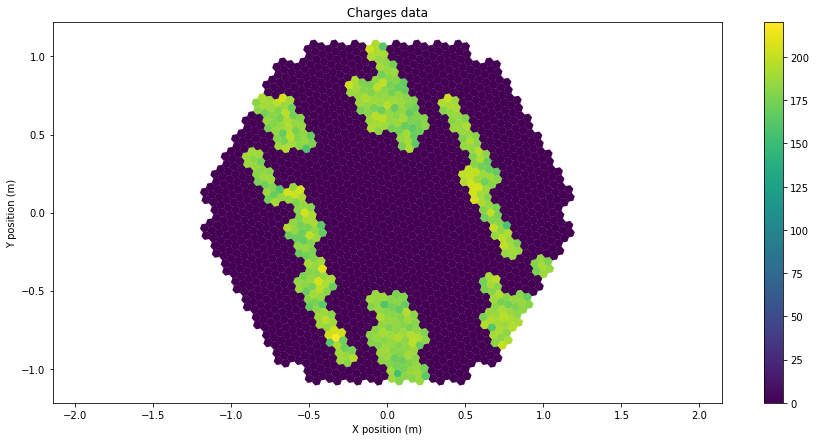

In [15]:
disp1 = CameraDisplay(geom,title='Charges data')
disp1.add_colorbar()
img = np.arange(1855)*0
img[pix_ids] = Qs_data
disp1.image = img

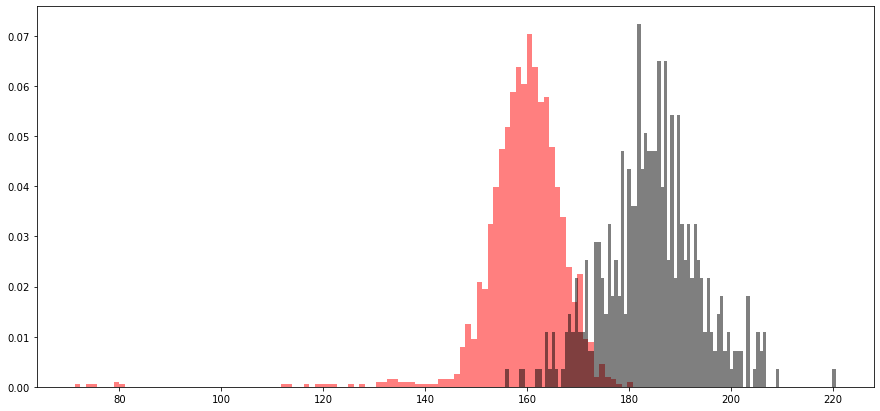

In [16]:
h = plt.hist(Qs[mmask],100,color='red',alpha=.5,density=1)
h = plt.hist(Qs_data,100,color='black',alpha=.5,density=1)

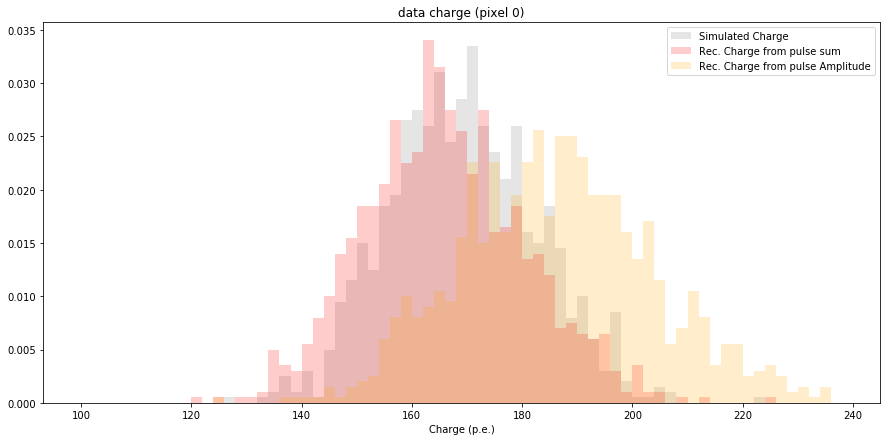

In [17]:
pix = 0
h= plt.hist(all_QMC[:,pix],bins=range(100,240,2),color='grey',alpha=.2,\
           label= "Simulated Charge",density=1)

h= plt.hist((wfs_MC[:,0,pix,40:56]-250.).sum(axis=1)/58.,bins=range(100,240,2),color='red',alpha=.2,\
           label= "Rec. Charge from pulse sum",density=1)
h= plt.hist((wfs_MC[:,0,pix,:]-250.).max(axis=1)/14.,bins=range(100,240,2),color='orange',alpha=.2,\
           label= "Rec. Charge from pulse Amplitude",density=1)



t = plt.gca().set_title('data charge (pixel {})'.format(pix))
t = plt.gca().set_xlabel('Charge (p.e.)')
l = plt.gca().legend()



15.685090171138835

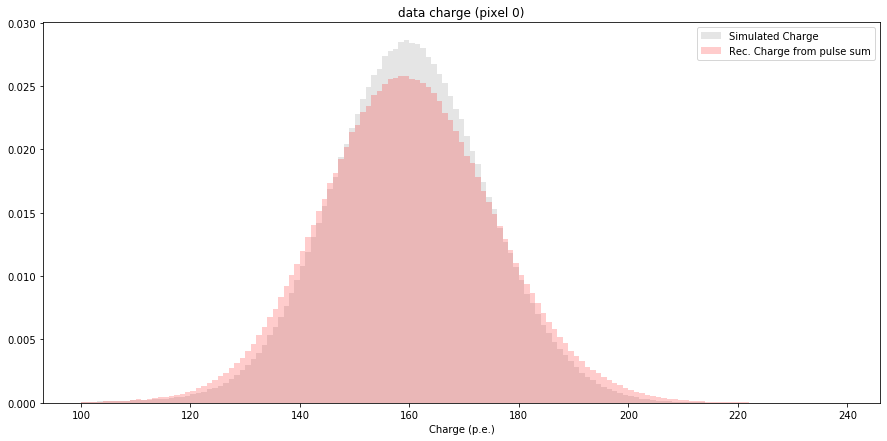

In [18]:
pix = 0
h= plt.hist(all_QMC[:,:].flatten(),bins=range(100,240,1),color='grey',alpha=.2,\
           label= "Simulated Charge",density=1)

h= plt.hist((wfs_MC[:,0,:,40:56]-250.).sum(axis=2).flatten()/58.,bins=range(100,240,1),color='red',alpha=.2,\
           label= "Rec. Charge from pulse sum",density=1)
#h= plt.hist((wfs_MC[:,0,:,:]-250.).max(axis=2).flatten()/14,bins=range(100,240,1),color='orange',alpha=.2,\
#           label= "Rec. Charge from pulse Amplitude",density=1)



t = plt.gca().set_title('data charge (pixel {})'.format(pix))
t = plt.gca().set_xlabel('Charge (p.e.)')
l = plt.gca().legend()

((wfs_MC[:,0,:,40:56]-250.).sum(axis=2).flatten()[mm]/58.).std()#/((wfs_MC[:,0,:,40:]-250.).sum(axis=2).flatten()/58.).mean()

Text(0.5, 1.0, 'Amplitude Vs Charge')

/local/home/ttaverni/anaconda3/envs/nectarchain-dev/lib/python3.7/site-packages/IPython/core/events.py:88: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  func(*args, **kwargs)
/local/home/ttaverni/anaconda3/envs/nectarchain-dev/lib/python3.7/site-packages/IPython/core/pylabtools.py:128: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


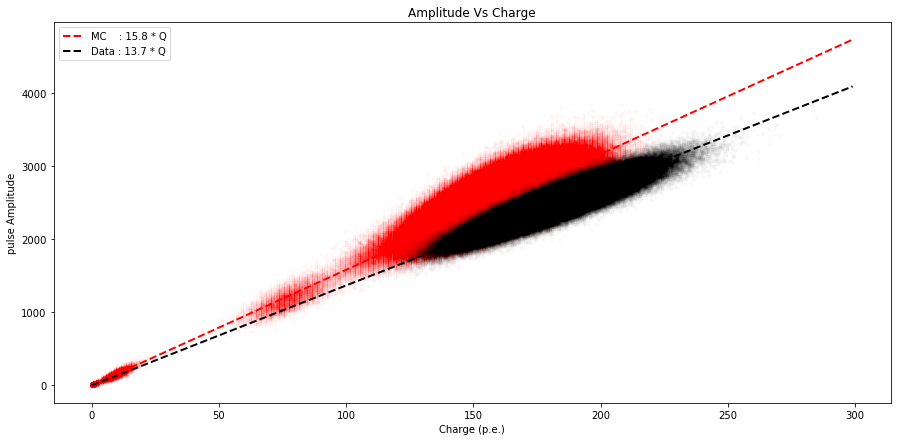

In [19]:
aa = all_QMC.flatten()
bb = (wfs_MC[:,0,:,:]-250.).max(axis=2).flatten()
mm = aa != 0

QA = (bb[mm]/aa[mm]).mean()

pp = plt.plot(all_QMC.flatten(),(wfs_MC[:,0,:,:]-250.).max(axis=2).flatten(),\
              '.',alpha=.01,color = 'red')
pp = plt.plot(np.arange(300),np.arange(300)*QA,'--',color = 'red',\
              lw=2, label="MC    : {:.3} * Q".format(QA))

pp = plt.plot(((wfs_data[:,0,:,20:40]-250.).sum(axis=2)/58.).flatten(),(wfs_data[:,0,:,:]-250.).max(axis=2).flatten(),\
              '.',alpha=.01,color = 'black')


QAdat = ((wfs_data[:,0,:,:]-250.).max(axis=2).flatten()/((wfs_data[:,0,:,20:40]-250.).sum(axis=2)/58.).flatten()).mean()

pp = plt.plot(np.arange(300),np.arange(300)*QAdat,'--',color = 'black',\
              lw=2, label="Data : {:.3} * Q".format(QAdat))

plt.gca().legend()
plt.gca().set_xlabel("Charge (p.e.)")
plt.gca().set_ylabel("pulse Amplitude")
plt.gca().set_title("Amplitude Vs Charge")

Text(0, 0.5, 'pulse Amplitude')

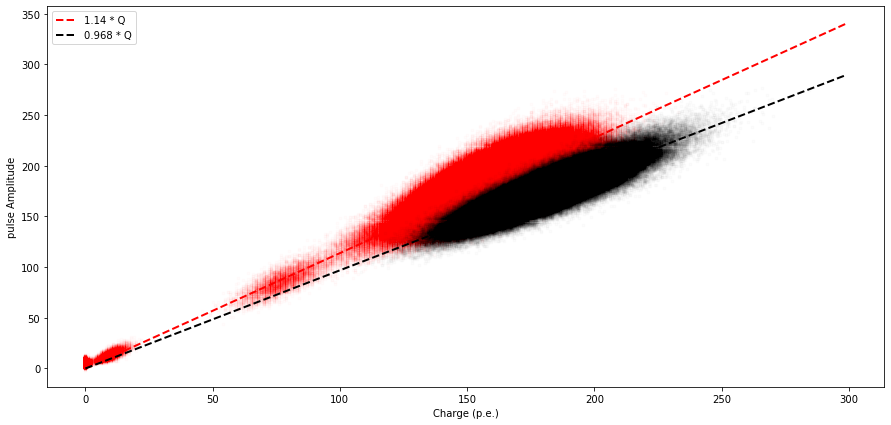

In [20]:
aa = all_QMC.flatten()
bb = (wfs_MC[:,1,:,:]-250.).max(axis=2).flatten()
mm = aa != 0

QA = (bb[mm]/aa[mm]).mean()

pp = plt.plot(all_QMC.flatten(),(wfs_MC[:,1,:,:]-250.).max(axis=2).flatten(),\
              '.',alpha=.01,color = 'red')
pp = plt.plot(np.arange(300),np.arange(300)*QA,'--',color = 'red',\
              lw=2, label="{:.3} * Q".format(QA))

pp = plt.plot(((wfs_data[:,0,:,20:40]-250.).sum(axis=2)/58.).flatten(),(wfs_data[:,1,:,:]-250.).max(axis=2).flatten(),\
              '.',alpha=.01,color = 'black')


QAdat = ((wfs_data[:,1,:,:]-250.).max(axis=2).flatten()/((wfs_data[:,0,:,20:40]-250.).sum(axis=2)/58.).flatten()).mean()

pp = plt.plot(np.arange(300),np.arange(300)*QAdat,'--',color = 'black',\
              lw=2, label="{:.3} * Q".format(QAdat))

plt.gca().legend()
plt.gca().set_xlabel("Charge (p.e.)")
plt.gca().set_ylabel("pulse Amplitude")

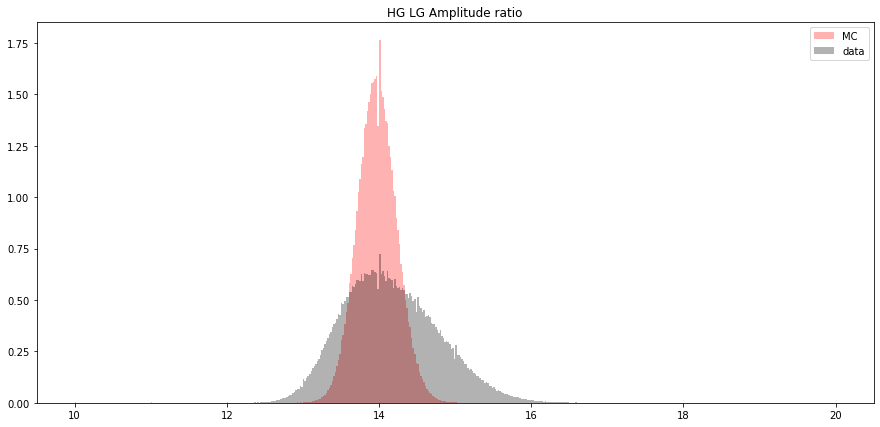

In [21]:
h =plt.hist((wfs_MC[:,0,:,:]-250.).max(axis=2).flatten()[mm]/(wfs_MC[:,1,:,:]-250.).max(axis=2).flatten()[mm],\
            500,range=(10,20),alpha=.3,color='red',density=1.,label='MC')

#h =plt.hist((wfs_MC[:,0,:,40:]-250.).sum(axis=2).flatten()[mm]/(wfs_MC[:,1,:,40:]-250.).sum(axis=2).flatten()[mm],\
#            500,range=(10,20),alpha=.3)
h =plt.hist((wfs_data[:,0,:,:]-250.).max(axis=2).flatten()/(wfs_data[:,1,:,:]-250.).max(axis=2).flatten(),\
            500,range=(10,20),alpha=.3,color='black',density=1.,label='data')
plt.gca().set_title('HG LG Amplitude ratio')
plt.gca().legend()

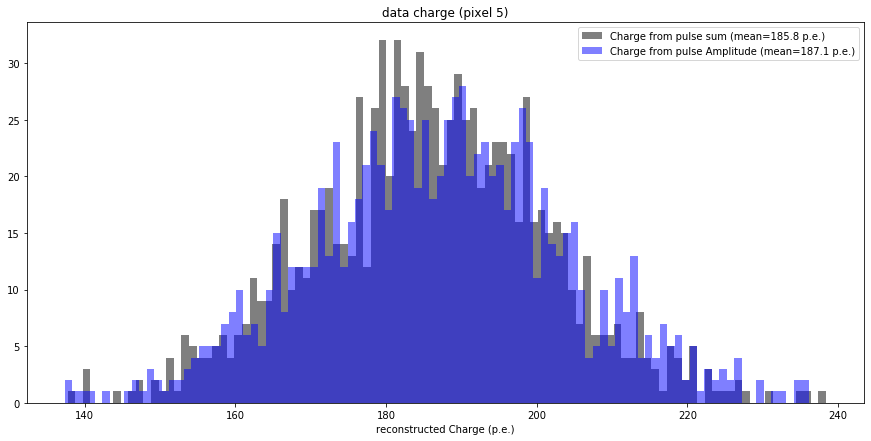

In [22]:
pix = 5
Qsum = (wfs_data[:,0,pix,20:40]-pedwfs[0,pix,20:40]).sum(axis=1)/58.
Qamp = (wfs_data[:,0,pix,:]-pedwfs[0,pix]).max(axis=1)/13.7

h = plt.hist(Qsum,100,color='black',alpha=.5,\
           label= "Charge from pulse sum (mean={:.4} p.e.)".format(Qsum.mean() ))
h = plt.hist(Qamp,100,color='blue',alpha=.5,\
           label= "Charge from pulse Amplitude (mean={:.4} p.e.)".format(Qamp.mean() ))

t = plt.gca().set_title('data charge (pixel {})'.format(pix))
t = plt.gca().set_xlabel('reconstructed Charge (p.e.)')
l = plt.gca().legend()


0.10022211737701257

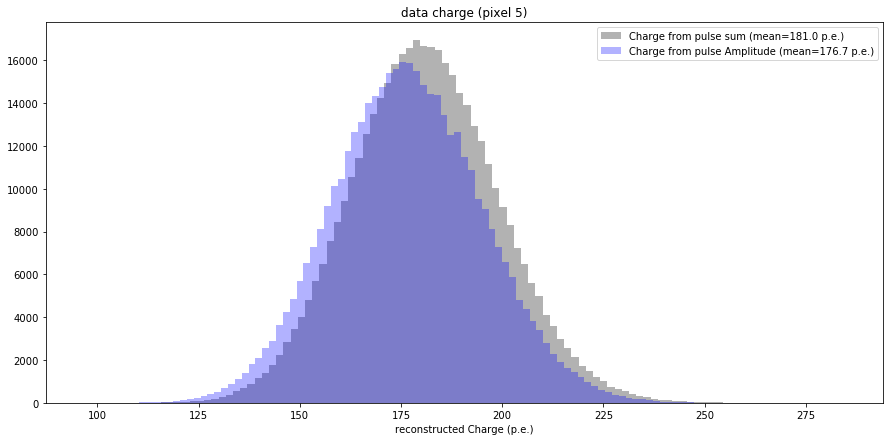

In [23]:
pix = 5
Qsum = (wfs_data[:,0,:,20:40]-pedwfs[0,pix,20:40]).sum(axis=2).flatten()/58.
Qamp = (wfs_data[:,0,:,:]-pedwfs[0,pix]).max(axis=2).flatten()/14

h = plt.hist(Qsum,100,color='black',alpha=.3,\
           label= "Charge from pulse sum (mean={:.4} p.e.)".format(Qsum.mean() ))
h = plt.hist(Qamp,100,color='blue',alpha=.3,\
           label= "Charge from pulse Amplitude (mean={:.4} p.e.)".format(Qamp.mean() ))

t = plt.gca().set_title('data charge (pixel {})'.format(pix))
t = plt.gca().set_xlabel('reconstructed Charge (p.e.)')
l = plt.gca().legend()
Qsum.std()/Qsum.mean()

In [24]:
#from cta.MyNectar.scripts.Nectarpipe.MakePTemplate import * 
from MakePTemplate_aftp import GetSyncSpePulseShape_aftp

In [25]:
QAmp = np.mean( (wfs_data[:,0,pix,20:40]-250.).sum(axis=1)/58.)
pixs=[0,1]
pix=4
#fct_dat,tmax_dat,shft_dat,Tstd_dat = GetSyncSpePulseShape(wfs_data,500,4,0,pixs,ManualShift = 0,QAmp = 14.)

In [26]:
apt = []
sss = np.arange(0,60,.25)
for pix in range(10):
    pwfs = wfs_data[:,0,pix,:] - pedwfs[0,pix]
    fct_dat,tmax_dat,shft_dat,Tstd_dat = GetSyncSpePulseShape_aftp(pwfs,4,ManualShift = 0)
    apt.append(fct_dat(sss+np.mean(shft_dat))/len(wfs_data))

T_0 : 30.0 ns
shft 1.7049182245857857
Tstd ::  0.30374131801113724
T_0 : 30.0 ns
shft 1.7058733097665777
Tstd ::  0.3029961743358873
T_0 : 30.0 ns
shft 1.3952126277600008
Tstd ::  0.3855718398489638
T_0 : 30.0 ns
shft 1.4718831917247823
Tstd ::  0.3823525904149049
T_0 : 30.0 ns
shft 1.3658425646081354
Tstd ::  0.3940035128591384
T_0 : 30.0 ns
shft 1.5521044215213426
Tstd ::  0.35073620120592697
T_0 : 30.0 ns
shft 1.9039852396822876
Tstd ::  0.3044779684035413
T_0 : 30.0 ns
shft 2.3715584018237363
Tstd ::  0.38967860512556324
T_0 : 30.0 ns
shft 2.642917361870562
Tstd ::  0.3023167408868866
T_0 : 30.0 ns
shft 2.064507837421523
Tstd ::  0.34437814427203833


In [27]:
#pwfs = wfs_data[:,0,pix,:] - pedwfs[0,pix]
#fct_dat,tmax_dat,shft_dat,Tstd_dat = GetSyncSpePulseShape_aftp(pwfs,4,ManualShift = 0)

In [28]:
QAmp_MC = np.mean( (wfs_data[:,0,pix,20:40]-250.).sum(axis=1)/58.)
#fct_mc,tmax_mc,shft_mc,Tstd_mc = GetSyncSpePulseShape(wfs_MC,500,4,0,pixs,ManualShift = 0,QAmp = 14.)
fct_mc,tmax_mc,shft_mc,Tstd_mc = GetSyncSpePulseShape_aftp(wfs_MC[:,0,1,:]-250.,4,ManualShift = 0)

T_0 : 30.0 ns
shft 18.19472275059839
Tstd ::  0.36044951784814017


In [29]:
ff3 ="./PT25.dat"

f= open(ff3,'r')
sss3 =[]
p_template3=[]
for line in f.readlines():
    al = np.array(line.split(),dtype=np.float)
    if len(al)>2:  
        sss3.append(al[0])
        p_template3.append(al[1])
p_template3= np.array(p_template3)
Tar2  = np.arange(-1.,1+1/8.,1/8.)
ggg_TTS = stats.norm.pdf(Tar2,0,.64)
CPT_spe = np.convolve(p_template3,ggg_TTS,"same")/8.

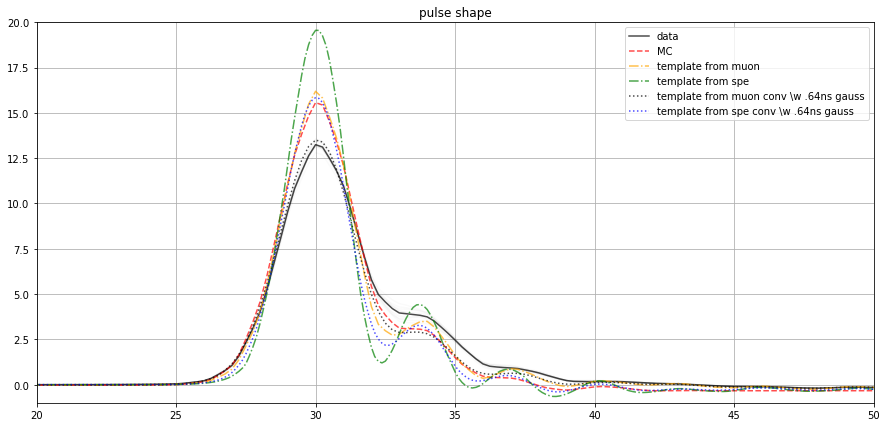

In [40]:
ff2 ="./Pulse_template_nectarCam_22112018.dat"

f= open(ff2,'r')
sss =[]
p_template=[]
for line in f.readlines():
    al = np.array(line.split(),dtype=np.float)
    if len(al)>2:  
        sss.append(al[0])
        p_template.append(al[1])

ff2 ="./PT8.dat"

f= open(ff2,'r')
sss2 =[]
p_template2=[]
for line in f.readlines():
    al = np.array(line.split(),dtype=np.float)
    if len(al)>2:  
        sss2.append(al[0])
        p_template2.append(al[1])

ff3 ="./PTSPE.dat"

f= open(ff3,'r')
sss3 =[]
p_template3=[]
for line in f.readlines():
    al = np.array(line.split(),dtype=np.float)
    if len(al)>2:
        sss3.append(al[0])
        p_template3.append(al[1])
        

ss = np.arange(60)
apt=np.array(apt)
#plt.plot(sss,fct_dat(sss+np.mean(shft_dat))/len(wfs_data),':',color='black',label="data",alpha=.7)
plt.plot(np.arange(0,60,.25),apt.mean(axis=0),'-',color='black',label="data",alpha=.7)
plt.plot(np.arange(0,60,.25),apt.T,'-',color='black',alpha=.02)

plt.plot(sss,fct_mc(sss+np.mean(shft_mc))/len(wfs_MC),'--',color='red',label='MC',alpha=.7)
#plt.plot(np.array(sss),p_template,'-.',color='blue',label="old template",alpha=1.)
plt.plot(np.array(sss2),p_template2,'-.',color='orange',label="template from muon",alpha=.7)
plt.plot(np.array(sss3),p_template3,'-.',color='green',label="template from spe",alpha=.7)

Tar    = np.arange(-1,1.25,.25)
TTS_g  = stats.norm.pdf(Tar,0,.64)
CPT    = np.convolve(p_template2,TTS_g,"same")/4.

Tar2   = np.arange(-1,1+1/8. ,1/8.)
TTS_g2 = stats.norm.pdf(Tar2,0,.64)
CPT2   = np.convolve(p_template3,TTS_g2,"same")/8.

plt.plot(np.array(sss2),CPT ,':',color='black',label="template from muon conv \w .64ns gauss",alpha=.7)
plt.plot(np.array(sss3),CPT2,':',color='blue',label="template from spe conv \w .64ns gauss",alpha=.7)

l = plt.gca().legend()
plt.gca().set_title('pulse shape')
plt.gca().set_xlim(20,50)
plt.gca().set_ylim(-1,20)
plt.gca().grid()

In [31]:
fct_mc(ss+np.mean(shft_mc))[20:40].max()/len(wfs_MC)


15.56604807929152

In [32]:
fct_dat(ss+np.mean(shft_dat))[20:40].max()/len(wfs_data)

13.247325028142464

In [33]:
fct_mc(ss+np.mean(shft_mc))[24:40].sum()/len(wfs_MC)

58.02724163853773

In [34]:
fct_dat(ss+np.mean(shft_dat)).sum()/len(wfs_data)

56.146715917291594

In [35]:
np.array(p_template2)[20*4:40*4:4].sum()

57.986

In [36]:
np.array(p_template)[:].max()

14.002

In [37]:
apt.mean(axis=0).max()

13.246738805321021